In [18]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
import keras_tuner as kt
import json
import pandas as pd
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import json
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
pd.set_option('display.max_columns', None)


In [2]:
df = pd.read_stata('lendingclub_train.dta')
# df.head()
# df.describe()
columns_to_drop = [
    "index",
    "depvar",
    "total_acc", 
    "out_prncp", 
    "out_prncp_inv", 
    "total_pymnt", 
    "total_pymnt_inv", 
    "total_rec_prncp", 
    "total_rec_int", 
    "total_rec_late_fee", 
    "recoveries", 
    "collection_recovery_fee",
    "last_pymnt_amnt", 
    # "last_fico_range_high", 
    # "last_fico_range_low", 
    # "tot_coll_amt", 
    # "tot_cur_bal", 
    "initial_list_status1", 
    "initial_list_status2", 
    "elapsed_t",
    "purpose1",
    "addr_state1",
    "elapsed_t",
    "debt_settlement_flag1",
    "term1",
    "mths_since_last_delinq1",
    "mths_since_last_major_derog1",
    "mths_since_last_record1",
    "mths_since_rcnt_il1",
    "mths_since_recent_bc1",
    "mths_since_recent_bc_dlq1",
    "mths_since_recent_inq1",
    "mths_since_recent_revol_delinq1"
]

issue_d_count = 1
while(issue_d_count <= 118):
    word_tmp = "issue_d" + str(issue_d_count)
    columns_to_drop.append(word_tmp)
    issue_d_count += 1


### Undersampling Logic
Undersampling을 안할거면 다음 로직 실행

In [37]:
# Separate majority and minority classes
df_majority = df[df['depvar'] == 0]
df_minority = df[df['depvar'] == 1]

# Count number of instances in the minority class
minority_count = len(df_minority)

# Undersample the majority class
df_majority_undersampled = df_majority.sample(n=minority_count*2, random_state=42)

# Combine minority class with the undersampled majority class
df_undersampled = pd.concat([df_majority_undersampled, df_minority])

# Shuffle the dataset
df_undersampled = df_undersampled.sample(frac=1, random_state=42)

# Now split into features and target, and then into training and testing sets
y = df_undersampled['depvar']
X = df_undersampled.drop(columns=columns_to_drop)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# X.info(verbose=True,max_cols=None)
# y.head()
X.head()


,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,collections_12_mths_ex_med,acc_now_delinq,chargeoff_within_12_mths,delinq_amnt,pub_rec_bankruptcies,tax_liens,emp_length1,emp_length2,emp_length3,emp_length4,emp_length5,emp_length6,emp_length7,emp_length8,emp_length9,emp_length10,emp_length11,emp_length12,home_ownership1,home_ownership2,home_ownership3,home_ownership4,home_ownership5,home_ownership6,verification_status1,verification_status2,verification_status3,purpose2,purpose3,purpose4,purpose5,purpose6,purpose7,purpose8,purpose9,purpose10,purpose11,purpose12,purpose13,purpose14,addr_state2,addr_state3,addr_state4,addr_state5,addr_state6,addr_state7,addr_state8,addr_state9,addr_state10,addr_state11,addr_state12,addr_state13,addr_state14,addr_state15,addr_state16,addr_state17,addr_state18,addr_state19,addr_state20,addr_state21,addr_state22,addr_state23,addr_state24,addr_state25,addr_state26,addr_state27,addr_state28,addr_state29,addr_state30,addr_state31,addr_state32,addr_state33,addr_state34,addr_state35,addr_state36,addr_state37,addr_state38,addr_state39,addr_state40,addr_state41,addr_state42,addr_state43,addr_state44,addr_state45,addr_state46,addr_state47,addr_state48,addr_state49,addr_state50,addr_state51,mths_since_last_delinq2,mths_since_last_delinq3,mths_since_last_delinq4,mths_since_last_delinq5,mths_since_last_delinq6,mths_since_last_delinq7,mths_since_last_delinq8,mths_since_last_delinq9,mths_since_last_delinq10,mths_since_last_delinq11,mths_since_last_major_derog2,mths_since_last_major_derog3,mths_since_last_major_derog4,mths_since_last_major_derog5,mths_since_last_major_derog6,mths_since_last_major_derog7,mths_since_last_major_derog8,mths_since_last_major_derog9,mths_since_last_major_derog10,mths_since_last_major_derog11,mths_since_last_record2,mths_since_last_record3,mths_since_last_record4,mths_since_last_record5,mths_since_last_record6,mths_since_last_record7,mths_since_last_record8,mths_since_last_record9,mths_since_last_record10,mths_since_last_record11,mths_since_rcnt_il2,mths_since_rcnt_il3,mths_since_rcnt_il4,mths_since_rcnt_il5,mths_since_rcnt_il6,mths_since_rcnt_il7,mths_since_rcnt_il8,mths_since_rcnt_il9,mths_since_rcnt_il10,mths_since_rcnt_il11,mths_since_recent_bc2,mths_since_recent_bc3,mths_since_recent_bc4,mths_since_recent_bc5,mths_since_recent_bc6,mths_since_recent_bc7,mths_since_recent_bc8,mths_since_recent_bc9,mths_since_recent_bc10,mths_since_recent_bc11,mths_since_recent_bc_dlq2,mths_since_recent_bc_dlq3,mths_since_recent_bc_dlq4,mths_since_recent_bc_dlq5,mths_since_recent_bc_dlq6,mths_since_recent_bc_dlq7,mths_since_recent_bc_dlq8,mths_since_recent_bc_dlq9,mths_since_recent_bc_dlq10,mths_since_recent_bc_dlq11,mths_since_recent_inq2,mths_since_recent_inq3,mths_since_recent_inq4,mths_since_recent_inq5,mths_since_recent_inq6,mths_since_recent_inq7,mths_since_recent_inq8,mths_since_recent_inq9,mths_since_recent_inq10,mths_since_recent_revol_delinq2,mths_since_recent_revol_delinq3,mths_since_recent_revol_delinq4,mths_since_recent_revol_delinq5,mths_since_recent_revol_delinq6,mths_since_recent_revol_delinq7,mths_since_recent_revol_delinq8,mths_since_recent_revol_delinq9,mths_since_recent_revol_delinq10,mths_since_recent_revol_delinq11
348863,6150,6150,6150.0,0.1464,212.11,23148.0,20.01,1,660,664,0,9,0,4781,0.683,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0
159852,18825,18825,18825.0,0.1849,685.21,42000.0,28.43,0,680,684,0,9,0,12245,0.753,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [3]:
y = df['depvar']
X = df.drop(columns=columns_to_drop)
# X = df.drop(columns=['depvar','index'])

X.info(verbose=True,max_cols=None)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874335 entries, 0 to 874334
Data columns (total 188 columns):
 #    Column                            Dtype  
---   ------                            -----  
 0    loan_amnt                         int32  
 1    funded_amnt                       int32  
 2    funded_amnt_inv                   float64
 3    int_rate                          float64
 4    installment                       float64
 5    annual_inc                        float64
 6    dti                               float64
 7    delinq_2yrs                       int8   
 8    fico_range_low                    int16  
 9    fico_range_high                   int16  
 10   inq_last_6mths                    int8   
 11   open_acc                          int16  
 12   pub_rec                           int8   
 13   revol_bal                         int32  
 14   revol_util                        float64
 15   last_fico_range_high              int16  
 16   last_fico_range_lo

# Hyperparameter Tuning

In [7]:
# Split the dataset into tuning subset and remaining data
X_tuning, X_remaining, y_tuning, y_remaining = train_test_split(X, y, test_size=0.8, random_state=42)  # 20% for tuning

# Further split the tuning subset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_tuning, y_tuning, test_size=0.2, random_state=42)

# Compute class weights for the tuning subset
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weight_dict = dict(enumerate(class_weights))

def build_model(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=512, step=32), activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0, max_value=0.5, step=0.1)))
    model.add(Dense(1, activation='sigmoid'))  # Single output neuron

    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                  loss='binary_crossentropy',  # Binary crossentropy loss
                  metrics=['accuracy'])

    return model

tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='hyperband_tuning'
)

tuner.search(X_train, y_train, epochs=10, validation_data=(X_val, y_val), class_weight=class_weight_dict)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model
loss, accuracy = best_model.evaluate(X_val, y_val)
print(f"Test Accuracy: {accuracy:.2f}, Test Loss: {loss:.2f}")



# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Prepare the best hyperparameters for saving
best_hyperparameters = {
    'units': best_hps.get('units'),
    'dropout': best_hps.get('dropout'),
    'learning_rate': best_hps.get('learning_rate')
}

# Save the best hyperparameters to a JSON file
with open('best_hyperparameters.json', 'w') as f:
    json.dump(best_hyperparameters, f)

print("Best hyperparameters saved to 'best_hyperparameters.json'")

Reloading Tuner from hyperband/hyperband_tuning/tuner0.json
1093/1093 [==============================] - 1s 547us/step - loss: 0.9168 - accuracy: 0.8668
Test Accuracy: 0.87, Test Loss: 0.92
Best hyperparameters saved to 'best_hyperparameters.json'


# Model Training

In [19]:
X_train, X_test, y_train, y_test =  train_test_split(X_remaining, y_remaining, test_size=0.2, random_state=42)

# Class Weight
class_weights = compute_class_weight('balanced', classes=[0,1], y=y_train)
class_weight_dict = dict(enumerate(class_weights))


# Load best hyperparameters
with open('best_hyperparameters.json') as f:
    best_hps = json.load(f)

model_path = 'final_trained_model.h5'
if(os.path.exists):
    model = load_model(model_path)
else:
    model = Sequential()
    model.add(Dense(units=best_hps['units'], activation='relu', input_shape=(X_train.shape[1],)))
    model.add(Dropout(best_hps['dropout']))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(best_hps['learning_rate']),
                loss='binary_crossentropy',
                metrics=['accuracy'])

history = model.fit(X, y, epochs=100, batch_size=256, class_weight=class_weight_dict)  # Adjust epochs and batch_size as needed

# Save the final trained model
model.save('final_trained_model.h5')


Epoch 1/100
3416/3416 [==============================] - 9s 3ms/step - loss: 0.4352 - accuracy: 0.8328
Epoch 2/100
3416/3416 [==============================] - 9s 3ms/step - loss: 0.4351 - accuracy: 0.8320
Epoch 3/100
3416/3416 [==============================] - 9s 3ms/step - loss: 0.4343 - accuracy: 0.8325
Epoch 4/100
3416/3416 [==============================] - 8s 2ms/step - loss: 0.4344 - accuracy: 0.8319
Epoch 5/100
3416/3416 [==============================] - 8s 2ms/step - loss: 0.4347 - accuracy: 0.8315
Epoch 6/100
3416/3416 [==============================] - 6s 2ms/step - loss: 0.4353 - accuracy: 0.8325
Epoch 7/100
3416/3416 [==============================] - 5s 2ms/step - loss: 0.4351 - accuracy: 0.8317
Epoch 8/100
3416/3416 [==============================] - 6s 2ms/step - loss: 0.4351 - accuracy: 0.8320
Epoch 9/100
3416/3416 [==============================] - 6s 2ms/step - loss: 0.4346 - accuracy: 0.8324
Epoch 10/100
3416/3416 [==============================] - 6s 2ms/step - l

/Users/choeseung-u/programming/econometrics/econometrics/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


### Plot the learning 

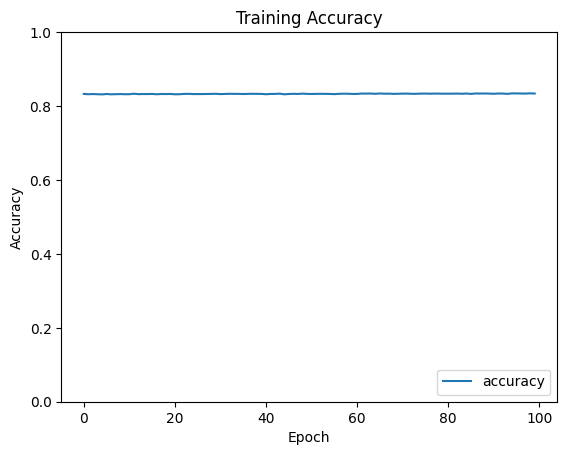

4372/4372 - 4s - loss: 0.3871 - accuracy: 0.8314 - 4s/epoch - 852us/step
Test accuracy: 0.8314437866210938
4372/4372 [==============================] - 4s 840us/step
Confusion Matrix:
 [[96064 21106]
 [ 2474 20250]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.97      0.82      0.89    117170
         1.0       0.49      0.89      0.63     22724

    accuracy                           0.83    139894
   macro avg       0.73      0.86      0.76    139894
weighted avg       0.90      0.83      0.85    139894



In [20]:

# Plotting the training history
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Training Accuracy')
plt.show()

# Evaluate the model on test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_accuracy}")

# Predictions for confusion matrix
y_pred = model.predict(X_test)
y_pred = np.round(y_pred).astype(int).reshape(-1)  # Adjust this line if not a binary classification

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)

# Precision, Recall, F1-Score
report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)